<a href="https://colab.research.google.com/github/ivan74rus/DS/blob/main/3_sprint_research_sale_aparts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 




### 1.Загрузка файла с данными и изучение общей  информации. 

In [ ]:
#подключить гугл диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt  #для графиков
df =  pd.read_csv('/content/drive/MyDrive/DS/real_estate_data.csv',sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

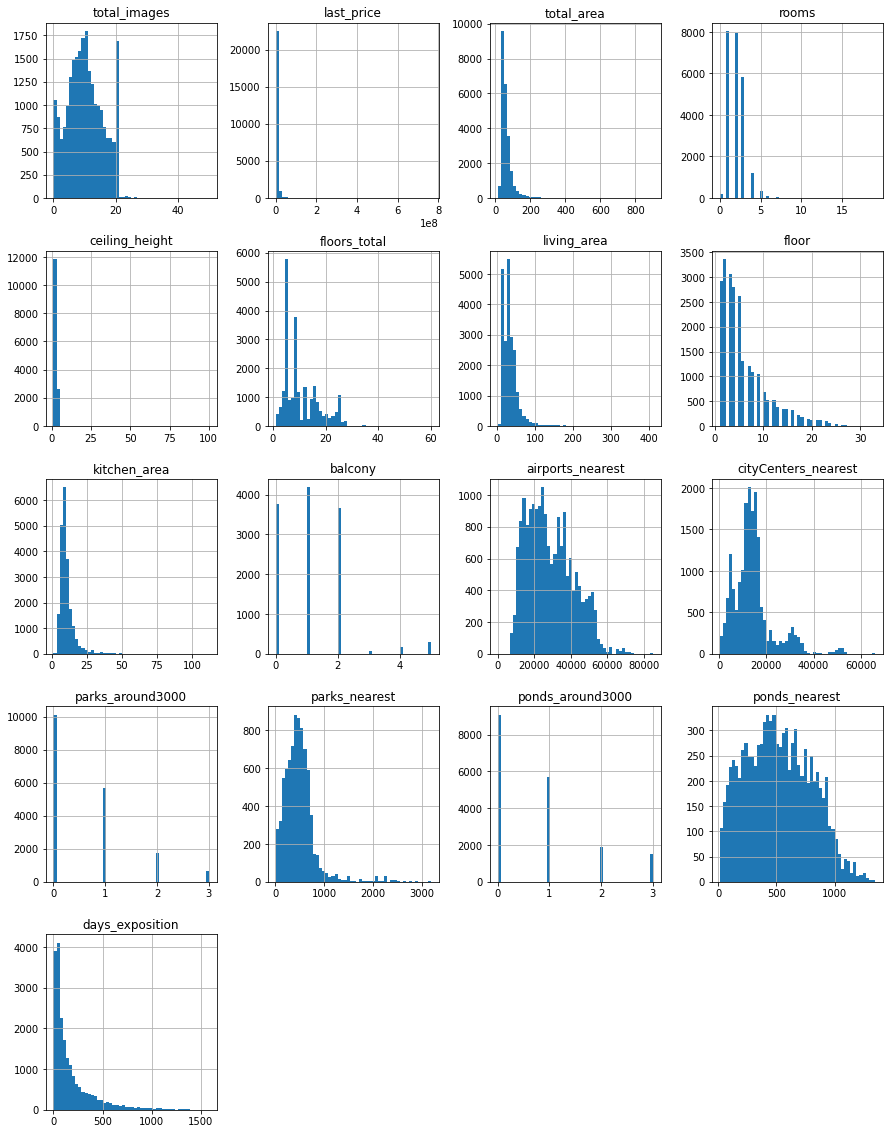

In [ ]:

df.hist(figsize=(15, 20), bins=50)
plt.show()

 **Вывод**: много пропусков,  гистограммы говорят, что в целом нет каких то больших выбросов данных.

### 2.Предобработка данных     
Заменим пропуски где возможно. Количество пропусков мы видели выше в df.info()

In [ ]:
#  для начала проверим дубликаты полные
df.duplicated().sum()

0

2.1  **Пропуски ceiling_height** Высота потолка. Заменим медианой, т к высота полтока в целом одинакова для жилой площади.   
Но для начала изучим разброс данных. Может  есть много нестадартных значений или ошибок

In [ ]:
print ('Пропусков в столбце ceiling_height =', df['ceiling_height'].isna().sum())

Пропусков в столбце ceiling_height = 9195


In [ ]:
print('медиана высоты потолка=',df['ceiling_height'].median())  #медиана
df['ceiling_height'].describe() #посомтрим на данные


медиана высоты потолка= 2.65


count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Потолки от 1 до 100 м , явно ошибки в данных.    
Установим разумный предел потолков от 2.2 м до 12 м. Потолки в 12  м  в индивидуальных проектах могут быть и не стоит их отсекать.
Проверим используя срез кол-во записей

In [ ]:
df.query('ceiling_height <= 2.2  or ceiling_height >=12 ')['ceiling_height'].count()

39

Кол-во 39 это крайне мало и не существенно. Можно их заменить медианами. Не тратить время на замены типа : 25 на 2.5    


In [ ]:
#df['ceiling_height'].hist(range=(2.2,6 ),bins=50) # распределние внутри нужного диапазона

Заменим все пропуски медианой.

In [ ]:
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median() 
df['ceiling_height'].isna().sum()  # поверим пропуски

0

Заменим выбросы в данных медианой

In [ ]:
df.loc[(df['ceiling_height'] <= 2.2)|(df['ceiling_height'] >= 12) , 'ceiling_height'] = df['ceiling_height'].median()
df['ceiling_height'].describe() #посомтрим еще раз на данные после всех замен

count    23699.000000
mean         2.698454
std          0.236477
min          2.250000
25%          2.600000
50%          2.650000
75%          2.700000
max         10.300000
Name: ceiling_height, dtype: float64

2.2 **Пропуски floors_total** всего этажей в доме.    
Причем во floor нет пропусков

In [ ]:
print ('Пропусков в столбце floors_total =', df['floors_total'].isna().sum())

Пропусков в столбце floors_total = 86


In [ ]:
df['floors_total'].describe() # смотрим на данные тут все ок, отрицательных нет, а 60 этаж возможен в СПБ

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Пропусков мало, влияния не окажут особо, заменим числом из floor. Если заменить медианой могут быть казусы ,когда высота дома меньше чем этаж квартиры.

In [ ]:
df.loc[df['floors_total'].isna(), 'floors_total'] = df['floor']
df['floors_total'].isna().sum() #проверяем пропуски

0

2.3 **Пропуски living_area** Жилая площадь.


In [ ]:
print ('Пропусков в столбце living_area =', df['living_area'].isna().sum()) # пропуски
df['living_area'].describe() # смотрим на данные

Пропусков в столбце living_area = 1903


count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Пропусков много. Есть еще стобец без пропусков с общей площадью квартиры.Можно заменить  через  медианное значение отношения общей площади помещения к жилой площади.

In [ ]:
#df[df['living_area'].isna()] # посмотрели данные
living_area_total_area_median = ( df['living_area']/ df['total_area']).median() # медиана  Sжилой / Sобщей до обработки
#добавил переменную,ч тобы не запутаться)
print ('медиана  Sжилой / Sобщей до обработки',living_area_total_area_median)      

df.loc[df['living_area'].isna(), 'living_area'] = living_area_total_area_median * df['total_area'] # меняем 
df['living_area'].isna().sum() #проверяем пропуски

медиана  Sжилой / Sобщей до обработки 0.5678598992678503


0

2.4 **Пропуски is_apartment** Апартаменты   
Большая часть данных - пропуски. Можно все пропуски заполнить, False, потому что квартиры это не апартаменты.

In [ ]:
print ('Пропусков в столбце is_apartment',df['is_apartment'].isna().sum()) #кол-во пропусков
df['is_apartment'].unique()                              # нужно еще поменять тип данных на bool

Пропусков в столбце is_apartment 20924


array([nan, False, True], dtype=object)

Большая часть данных - пропуски. Можно все пропуски заполнить, False, потому что квартиры это не апартаменты.

In [ ]:
df.loc[df['is_apartment'].isna(), 'is_apartment'] = False    # заменяем пропуски 
df['is_apartment'] = df['is_apartment'].astype(bool)         # земеним тип данных
    
df['is_apartment'].isna().sum()                              # еще раз проверим кол-во пропусков

0

In [ ]:
df['is_apartment'].value_counts()    # оценим кол-во аппартаментов в этом дата сете, крайне мало.
#df.info()   # проверка дата сета 

False    23649
True        50
Name: is_apartment, dtype: int64

2.5 **Пропуски kitchen_area** площадь кухни.   
Оставим пропуски.Как вариант, можно их так же как жилую площадь средним медианным отношением к площади квартиры заполнить, пока не будем.

In [ ]:
df['kitchen_area'].describe() # посмотрим еще раз на данные
#df.boxplot('kitchen_area')    # различными способами


count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

2.6 **Пропуски в balcony**  наличие балкона
Пропусков около половины. Менять пропуски на отсувие балкона (0) рекомендуется в анатоции проекта от яндекса.    
Лично я думаю,ч то это спорно, но заменим.

In [ ]:
df['balcony'].unique() # смотрим значения

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [ ]:
df.loc[df['balcony'].isna(), 'balcony'] = 0 #заменим пропуски 0
df['balcony'] = df['balcony'].astype(int)  # Тип даных на целочисленный поменяем
df['balcony'].head()                      # проверим
df['balcony'].isna().sum()                 # проверим сколько 
df['balcony'].value_counts()             

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64

получаем , что бОльшая часть квратир без балконов,что сомнительно, может это какая то спекцифика СПБ конечно.

2.7 **Пропуски locality_name**  название населенного пункта.     
Посмотрим данные.

In [ ]:
df['locality_name'].isna().sum()

49

In [ ]:
#Всего 49 пропусков, удалять не будем. Заменим их на 'noname'
df.loc[df['locality_name'].isna(), 'locality_name'] = 'noname'
df['locality_name'].isna().sum()  #проверим

0

2.8  **Пропуски в картографических данных : airports_nearest , cityCenters_nearest** 
**parks_around3000, parks_nearest, ponds_around3000, ponds_nearest**      
Скорее всего для разлчиный послеоков, деревень и тд нет ближайших аэропортов ,парков и парковок. ТОчнее алгоритм не отпределяет их. ПОэтому  и пропуски.    
Оценим по населенным пунктам   

In [ ]:
# возьемем так же любой полный столбец(room) , для оценки кол-ва объявлений по каждому населенному пункту)
df.pivot_table(index='locality_name', values= ['rooms','airports_nearest','cityCenters_nearest','parks_around3000','ponds_around3000'] ,\
               aggfunc='count').sort_values(by='rooms',ascending=False).head(15).rename(columns={'rooms' :'счетчик_обявлений' })


,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,счетчик_обявлений
locality_name,,,,,
Санкт-Петербург,15636,15660,15660,15660,15721
посёлок Мурино,0,0,0,0,522
посёлок Шушары,436,436,436,436,440
Всеволожск,0,0,0,0,398
Пушкин,369,368,369,369,369
Колпино,337,337,337,337,338
посёлок Парголово,327,327,327,327,327
Гатчина,0,0,0,0,307
деревня Кудрово,0,0,0,0,299


Как видно действительно есть населенные пункты где картографический алгоритм не заполнилняет значения.   
Немного пропусков есть и СПБ, но их  крайне мало.   
Пропуски в картографических данных оставим. 


In [ ]:
#map_data = ['airports_nearest' , 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']
#for i in  map_data:
#    df.loc[df[i].isna(), i] = 0

2.9 **days_exposition** сколько дней было размещено объявление (от публикации до снятия)

In [ ]:
df['days_exposition'].isna().sum()

3181

Приличное кол-во пропусков.    
Похоже ,  на момент  создания датасета  объявления были  не сняты.     
Можно примерно определить дату датасета df_date = 'first_day_exposition'.max() + days_exposition.    
И пропускам выставить      df_date - 'first_day_exposition'.    
Но, возможно, это и не надо делать.  Т к если обьявления не завершены, квартиры не проданы, их нужно выкинуть из анализа.    
Проверим гипотезу, что это не завершенные обявления. И найдем дату датасета исходного по данным.


**Общий вывод по пропускам***. Заполнили, что возможно.    
Часть пропусков возникло из-за того что люди  не все данные заполнили.     
Картографические должны были автоматически заполнится.Скоре всего не для всех населных пунктов возможны все данные картографии. 

2.10 **Замена тип данныхв стобцах**   
first_day_exposition поменям на date_time  потмоу что это дата  
floors_total   поменяем на int      потмоу что число этажей целое 
balcony ранее поменяли на int       потому что число балконов целое
is_apartment  ранее поменяли на bool     


In [ ]:

#df['first_day_exposition'].head() #смотрим формат даты времни
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') # замена на datatime
df['floors_total'] = df['floors_total'].astype(int)   # замена на int


In [ ]:
df.info() #проверим что получилось по итогу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

2.11  **Уникальные значения в столбце с названиями**  locality_name
Необходимо устранить неявные дубликаты в столбце locality_name

In [ ]:
# len(df['locality_name'].unique()) # измерим массив значений...
print ('кол-во уникальных значений до  обработки:', df['locality_name'].nunique())

кол-во уникальных значений до  обработки: 365


In [ ]:
df['locality_name'].unique() #посмотрим значения

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

1.Заменим везде букву ё на е.    
2.Заменим различные варинаты написания поселка


In [ ]:
#сначала ё на е  заменим
df['locality_name'] = df['locality_name'].str.replace('ё', 'е') 
#затем поселки все приведем к единому виду
duplicates = ['поселок городского типа', 'городской поселок', 'поселок городского типа имени', 'городской поселок']
for _ in duplicates: 
    df['locality_name'] = df['locality_name'].str.replace(_, 'поселок') 
df['locality_name'].unique()     #проверим визуально
print ('кол-во уникальных значений после обработки:', df['locality_name'].nunique() )   # посчитаем кол-во

кол-во уникальных значений после обработки: 323


2.12 **Устрание редких и выбивающиеся значений**     
Часть  было сделано на этапе замены пропусков. Т к данные в каждом столбце анализирвоались, прежде чем заменять.    
Проведем проверку по столбцам с основными характеристиками квартир на наличие аномальных значений и исключим/заменим их.   
last_price , total_area, floors_total 

In [ ]:
#'last_price'
#Посчитаем слишком дорогие квартиры > 100кк  и < 500к 
print ('кол-во обяъвлений с аномальными ценами > 100кк  и < 500к :',\
       len(df.query('last_price > 100000000 or  last_price < 500000 ' ) ) )
# всего 51 значений , исключим  их.
df = df.query('last_price <= 100000000 or  last_price >= 500000 ' )



кол-во обяъвлений с аномальными ценами > 100кк  и < 500к : 51


In [ ]:
# всего 51 значений , исключим  их.
df = df.query('last_price <= 100000000 and  last_price >= 500000 ' )
len(df) # првоерим

23648

14

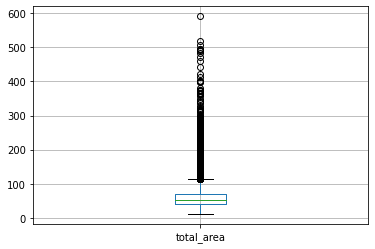

In [ ]:
#total_area
#df['total_area'].describe()
df.boxplot('total_area')
len(df.query('total_area > 400')) # 14  шт штук исключим

In [ ]:
# можно исключить > 400 кв м
df= df.query('total_area <= 400')
len(df) # провоерим

23634

2

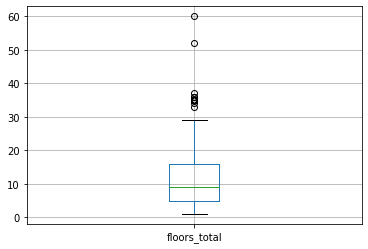

In [ ]:
#floors_total
df.boxplot('floors_total') # исключим больше 40
len(df.query('floors_total > 40'))

In [ ]:
# исключим больше 40 этажа
df =df.query('floors_total <= 40')
len(df) # проверим

23632

**Общий вывод по п 2**:   
Данные обработаны. Пропуски заменены , которые возможны.   
Пропуски в картографичесикх данных связаны с географией населенных пунктов  оставлены NaN.   
Выбросов аномальных  данных мало. См обзорные гистограммы вначале. Часть заменил медианой.  
Аномальные значения отброшены.

### 3.Подсчет  и добавление  в таблицу новых столбцов:

цена одного квадратного метра;      
день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);     
месяц публикации объявления;     
год публикации объявления;       
тип этажа квартиры (значения — «первый», «последний», «другой»);      
расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).      

In [ ]:
# one_m2_price = last_price / total_area  цена одного квадратного метра
df['one_m2_price'] = df['last_price'] / df['total_area']
#df['one_m2_price'].head()  #проверка

<ipython-input-42-350e57879be3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['one_m2_price'] = df['last_price'] / df['total_area']


In [ ]:
#day_of_week_exposition день недели публикации объявления
df['day_of_week_exposition'] =df['first_day_exposition'].dt.weekday
# df['day_of_week_exposition'] #проверка

<ipython-input-43-7a4179dce503>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week_exposition'] =df['first_day_exposition'].dt.weekday


In [ ]:
#month_exposition месяц публикации
df['month_exposition'] = df['first_day_exposition'].dt.month
#df['month_exposition'] #проверка

<ipython-input-44-6da64ecba233>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_exposition'] = df['first_day_exposition'].dt.month


In [ ]:
#year_exposition месяц публикации
df['year_exposition'] = df['first_day_exposition'].dt.year
#df['year_exposition'] # проверка

<ipython-input-45-038a13891c5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_exposition'] = df['first_day_exposition'].dt.year


In [ ]:
#floor_type тип этажа квартиры (значения — «первый», «последний», «другой»)
# используем цикл по индексу и сравним значения
#for  i in range(len(df)):
#    if df.loc[i ,'floor'] == df.loc[i, 'floors_total']:
#        df.loc[i,'floor_type'] = 'последний'
#    elif    df.loc[i ,'floor'] == 1:
#        df.loc[i,'floor_type'] = 'первый'
#    else:
#        df.loc[i,'floor_type'] = 'другой'


In [ ]:
# реализуем через функцию
def floor_type(x):
    if x['floor'] == 1:
        return 'первый'
    elif x['floor'] == x['floors_total']:
        return 'последний'
    return 'другой'

df['floor_type'] = df.apply(floor_type, axis=1)
df['floor_type'].unique()  # проверяем   


array(['другой', 'первый', 'последний'], dtype=object)

In [ ]:
#km_to_CityCentres расстояние до центра города в километрах
df['km_to_CityCentres'] = round(df['cityCenters_nearest']/1000)

# не могу понять почему не преврашает  в int
df[ df['km_to_CityCentres'].notna()]['km_to_CityCentres'].astype(int) # так все рабоает показывает как числа типа int
df['km_to_CityCentres'] = df[ df['km_to_CityCentres'].notna()]['km_to_CityCentres'].astype(int)

df['km_to_CityCentres']

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: km_to_CityCentres, Length: 23632, dtype: float64

### 4.Проведение исследовательского анализа данных

**4.1 Изучение и описание параметров данных**

In [ ]:
#общая площадь 'total_area'
df['total_area'].describe()
#df.boxplot('total_area')

count    23632.000000
mean        59.691850
std         31.890766
min         12.000000
25%         40.000000
50%         52.000000
75%         69.500000
max        400.000000
Name: total_area, dtype: float64

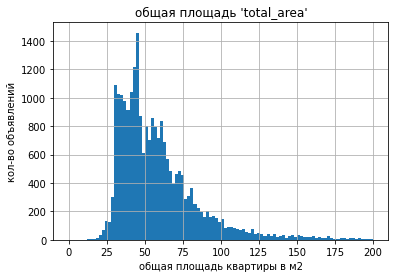

In [ ]:
plt.title("общая площадь 'total_area'")
plt.xlabel("общая площадь квартиры в м2")
plt.ylabel("кол-во объявлений")
df['total_area'].hist(range=(0,200),bins=100)
plt.show()

**общая площадь 'total_area'**   распределение данных тяготеет к нормальному.       
Больше в данных квартир с небольшой площадью от 30 до 50 кв м. Поэтому  медиана меньше среднего значения.   
С ростом метража кол-во квартир  быстро уменьшается.    
Каких то критичных выбросов в данных нет.

In [ ]:
# жилая площадь 'living_area'
df['living_area'].describe()

count    23632.000000
mean        34.208185
std         20.419120
min          2.000000
25%         19.000000
50%         30.000000
75%         42.000000
max        264.500000
Name: living_area, dtype: float64

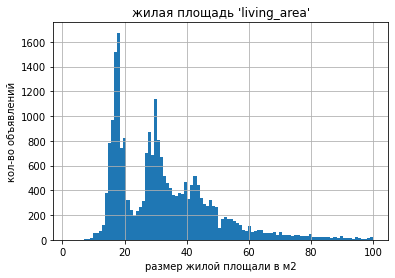

In [ ]:
plt.title("жилая площадь 'living_area'")
plt.xlabel("размер жилой площали в м2")
plt.ylabel("кол-во объявлений")
df['living_area'].hist(range=(2,100),bins=100)
plt.show()


**жилая площадь 'living_area'**   
В данных были пропуски, их заполнили медианой  отношения жилой площади к общей. потому что для типовых квартир это более менее стандартное отношение.  
На гистограммевидно  несколько ярких хаев(пиков). Самый бошой пик это жилая площадь как раз большого кол-ва маленьких квартир.   
Второй пик это жилая площадь квартир средних.     
Почему образовался такой ярко выраженный минимум между пиком 1 и пиком 2, вопрос интересный. Возможно, типовые проекты квартир так влияют.

In [ ]:
# площадь кухни  'kitchen_area'
df['kitchen_area'].describe()

count    21368.000000
mean        10.509052
std          5.671754
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

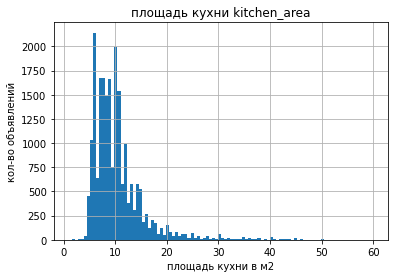

In [ ]:
plt.title('площадь кухни kitchen_area')
plt.xlabel('площадь кухни в м2')
plt.ylabel('кол-во объявлений') 
df['kitchen_area'].hist(range=(1,60), bins=100)
plt.show()

**площадь кухни  'kitchen_area'**    
Кухни в целом не большие. Т е значительно меньше больших кухнь.    
Распределение данных тяготеет к нормальному.   
График напоминает общию жилую площадь.   
Видны так же экстремумы соответсвующие  значениям площади типовым проектам мальнких квартир.
Пропуски в данных так же можно было заменить медианным значением отношения площади кухни к жилой. Но лучше для начало сгруппировать квартиры в малые средние большие и оч большие. В каждой группе наверника % от общей   для кухни будет отличаться.   

In [ ]:
#цена объекта 'last_price'
df['last_price'].describe()

count    2.363200e+04
mean     6.225877e+06
std      6.283149e+06
min      5.000000e+05
25%      3.400000e+06
50%      4.635500e+06
75%      6.750000e+06
max      9.900000e+07
Name: last_price, dtype: float64

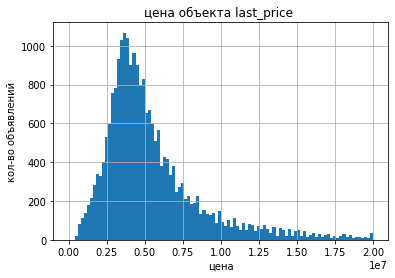

In [ ]:
plt.title('цена объекта last_price ')
plt.xlabel('цена')
plt.ylabel('кол-во объявлений') 
df['last_price'].hist(range=(0,20000000),bins=100)
plt.show()

**цена объекта 'last_price'**     
Распределения данных тяготеет к нормальному.   
Большое кол-во мальенких квартир вносит вклад. Поэтому медиана меньше среднего.  

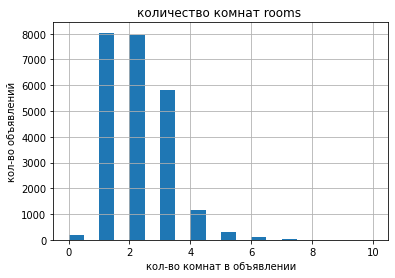

In [ ]:
#количество комнат 'rooms'
df['rooms'].describe()
plt.title('количество комнат rooms ')
plt.xlabel('кол-во комнат в объявлении')
plt.ylabel('кол-во объявлений') 
df['rooms'].hist(bins=20,range=(0,10))
plt.show()

**#количество комнат 'rooms'**   
Тут данные тоже примерно повторяют жилую площадь, так же большинство квартир с небольшим кол-вом комнат.  
Значения 0 это не факт ,ч то ошибки в данных,может студии маленькие так  пользователи обозначили.

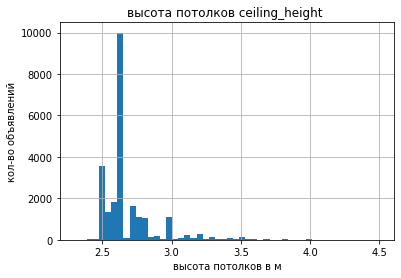

In [ ]:
#высота потолков 'ceiling_height'
df['ceiling_height'].describe()
plt.title('высота потолков ceiling_height ')
plt.xlabel('высота потолков в м')
plt.ylabel('кол-во объявлений') 
df['ceiling_height'].hist(bins=50, range=(2.3,4.5))
plt.show()

**высота потолков 'ceiling_height'**      
Высота потолков довольно стандартный параметр для квартир. Почти все данные лежат в узком диапазоне от 2.5 до 3.
Еще на стадии обработки данных пропуски были заменены на медиану. И установелен разумный предел потолков 2.2- 10.3 м. Значений выходящих за "разумный предел" оказалось совсем мало 39 - это явно ошибки в данных. И так как их кране мало , они вносят ничтожный вклад в данные, то были замененны на медианы.

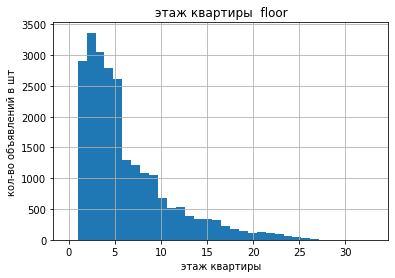

In [ ]:
#этаж квартиры ' floor'
df['floor'].describe()
plt.title('этаж квартиры  floor')
plt.xlabel('этаж квартиры')
plt.ylabel('кол-во объявлений в шт')
df['floor'].hist(range=(0,33), bins=34)
plt.show()

**этаж квартиры ' floor'**   
Этажность квартир показывае, что больше всего квартир на низких этажах продается. Что логично, потому как  часть домов низкоэтажные. 

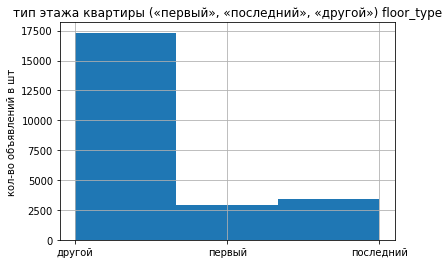

In [ ]:
#тип этажа квартиры («первый», «последний», «другой») 'floor_type'
df.groupby('floor_type')['floor_type'].count()
plt.title('тип этажа квартиры («первый», «последний», «другой») floor_type')
#plt.xlabel('тип этажа квартиры')
plt.ylabel('кол-во объявлений в шт')
df['floor_type'].hist(bins=3)
plt.show()

**#тип этажа квартиры («первый», «последний», «другой») 'floor_type'**  
Первых и последних примерно поровну. БОльшая часть посредине. Все как и положено.    

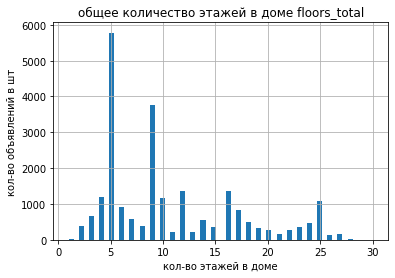

In [ ]:
# общее количество этажей в доме 'floors_total'
df['floors_total'].describe()
plt.title('общее количество этажей в доме floors_total')
plt.xlabel('кол-во этажей в доме')
plt.ylabel('кол-во объявлений в шт')
df['floors_total'].hist(bins=60, range=(1,30))
plt.show()

**общее количество этажей в доме 'floors_total'**   
тут сразу выделяются пики соотвествующие большому числу квартир из типовых проектов: 5, 9, 12, 16, 25 этажей.   
Невысоких домом большинство, поэтому большинство объявлений с небольшим этажом вквартир. 

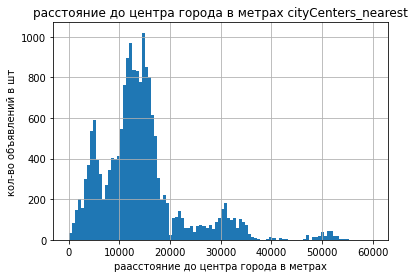

In [ ]:
#расстояние до центра города в метрах 'cityCenters_nearest'
df['cityCenters_nearest'].describe()
#print ('Кол-во объявлений где растояние до центра было пропуском:',df.query('cityCenters_nearest == 0')['cityCenters_nearest'].count())
plt.title('расстояние до центра города в метрах cityCenters_nearest')
plt.xlabel('раасстояние до центра города в метрах')
plt.ylabel('кол-во объявлений в шт')
df['cityCenters_nearest'].hist(bins=100, range = (0, 60000))
plt.show()

**расстояние до центра города в метрах 'cityCenters_nearest'**    
При обработке данных, пропуски были заменены 0. Для части населенных пунктов картографичесике данные не заполняются. Поэтому гистограмма начинается с 1.     
На графике выдно что большинство кварти расположены  на расстоянии межде 10 и 20 км от центра.  так же прослеживается пик квартир в центре на расстоянии 5 км.

In [ ]:
#расстояние до ближайшего аэропорта 'airports_nearest'

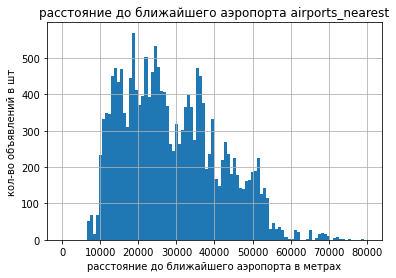

In [ ]:
df['airports_nearest'].describe()
plt.title('расстояние до ближайшего аэропорта airports_nearest')
plt.xlabel('расстояние до ближайшего аэропорта в метрах')
plt.ylabel('кол-во объявлений в шт')
df['airports_nearest'].hist(range =(1,80000), bins=100)
plt.show()

**расстояние до ближайшего аэропорта 'airports_nearest'**   
При обработке данных, пропуски были заменены 0. Для части населенных пунктов картографичесике данные не заполняются. Поэтому гистограмма начинается с 1.     
 Аэропорт находится за пределеами города. Поэтому квартиры начинаются в сононом с растояния 10км.

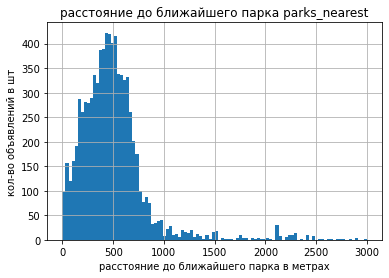

In [ ]:
#расстояние до ближайшего парка 'parks_nearest'
df['parks_nearest'].describe()
plt.title('расстояние до ближайшего парка parks_nearest')
plt.xlabel('расстояние до ближайшего парка в метрах')
plt.ylabel('кол-во объявлений в шт')
df['parks_nearest'].hist(bins=100,range=(0,3000))
plt.show()

**расстояние до ближайшего парка 'parks_nearest'**     

Для тех объявлений где указано расстояние до парка оно не большое до 1 км в  большинстве случаев.


In [ ]:
# день и месяц публикации объявления 'day_of_week_exposition'  &  'month_exposition'

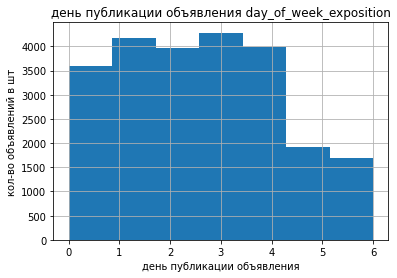

In [ ]:
plt.title('день публикации объявления day_of_week_exposition')
plt.xlabel('день публикации объявления')
plt.ylabel('кол-во объявлений в шт')
df['day_of_week_exposition'].hist(bins=7)
plt.show()

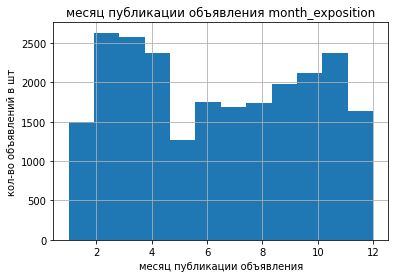

In [ ]:
plt.title('месяц публикации объявления month_exposition')
plt.xlabel('месяц публикации объявления')
plt.ylabel('кол-во объявлений в шт')
df['month_exposition'].hist(bins=12)
plt.show()

**день и месяц публикации объявления 'day_of_week_exposition'  &  'month_exposition'**    
Из дня недели видно, что в выходные размещают примерно в 2 раза меньше объявлений, чем в рабочие дни.    
Из месяца видно, что  меньше всего размещают в январе и мае, когда длинные выходные дни у всех.      
Из этого можно сделать вывод, что большую часть объявлений размещают риелторы в рабочие дни.

Среднее кол-во дней объявления на сайте : 180.65513196480939
Медиана кол-ва дней объявления на сайте: 95.0


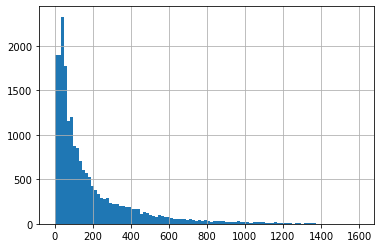

In [ ]:
# как быстро продавались квартиры 'days_exposition'
print ('Среднее кол-во дней объявления на сайте :', df['days_exposition'].mean() )
print ('Медиана кол-ва дней объявления на сайте:', df['days_exposition'].median() )
df['days_exposition'].describe()
df['days_exposition'].hist(bins=100,range=(0,1600))

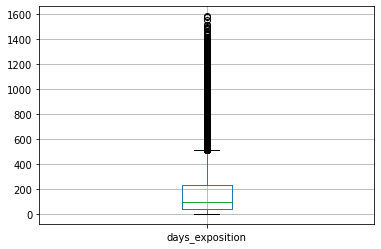

In [ ]:
df.boxplot('days_exposition')  #посмотрим разброс на ящике

**как быстро продавались квартиры 'days_exposition'**     
Обычно продажа занимает 95 дней.  
Быстрые продажи это меньше 45 дней.  
Необычно долгие это свыше 500 дней. 

In [ ]:
df['days_exposition'].describe()

count    20460.000000
mean       180.655132
std        219.529541
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

**4.2 Оценка факторов больше всего влияющих на общую (полную) стоимость объекта - last_price:**
  - общая площади -  total_area ;
  - жилой площади - living_area ;
  - площади кухни - kitchen_area;
  - количество комнат - rooms ;
  - типа этажа, на котором расположена квартира (первый, последний, другой) - floor_type ;
  - даты размещения (день недели, месяц, год) - day_of_week_exposition, month_exposition, year_exposition;

In [ ]:
# создадим дата сет с параметрами квартиры с котрыми будем оценивать  влияние на  полную стоимость 
df_apart_param = df.loc[:,['last_price','total_area','living_area',\
                           'kitchen_area','rooms','floor_type','day_of_week_exposition','month_exposition','year_exposition']]
df_apart_param.head(3) 

,last_price,total_area,living_area,kitchen_area,rooms,floor_type,day_of_week_exposition,month_exposition,year_exposition
0,13000000.0,108.0,51.0,25.0,3,другой,3,3,2019
1,3350000.0,40.4,18.6,11.0,1,первый,1,12,2018
2,5196000.0,56.0,34.3,8.3,2,другой,3,8,2015


In [ ]:
#Снача превратим floor_type в численный т к corr() не обработает str данные 
def floor_type_int (x):
    if x == 'первый':
        return 1
    if x == 'другой':
        return 5
    return 10
df_apart_param['floor_type'] = df_apart_param['floor_type'].apply(floor_type_int)
df_apart_param.head(3)

,last_price,total_area,living_area,kitchen_area,rooms,floor_type,day_of_week_exposition,month_exposition,year_exposition
0,13000000.0,108.0,51.0,25.0,3,5,3,3,2019
1,3350000.0,40.4,18.6,11.0,1,1,1,12,2018
2,5196000.0,56.0,34.3,8.3,2,5,3,8,2015


In [ ]:
#оценим кореряцию last_price  к  параметрам квартиры
#взаимосвязи между самими параметрами убраны  т к не нужны тут.
df_apart_param.corr()['last_price'].reset_index().rename(columns={'index' :'apart_param', 'last_price': 'corr_last_price' })

,apart_param,corr_last_price
0,last_price,1.000000
1,total_area,0.763625
2,living_area,0.680864
3,kitchen_area,0.587432
4,rooms,0.467787
5,floor_type,0.052196
6,day_of_week_exposition,-0.005248
7,month_exposition,0.007886
8,year_exposition,-0.053825


Как видноиз кореляции больше всего на полную стоимость влияет общая площадь ,хотя и не очень сильно.     
Затем  производные от нее жилая площадь и кухня. Количество комнат относительно слабо влияет.   
Этаж  совсем слабо влияет.     
День, месяц и год размещения объявления не влияют на стоимость квартир. 


In [ ]:
# для интереса посмотрим на тип этажа по другому
df.pivot_table(index='floor_type', values='last_price', aggfunc=('count', 'median'))

,count,median
floor_type,,
другой,17327,4835000.0
первый,2910,3900000.0
последний,3395,4345000.0


Видно, что первый этаж самый дешевый, затем идет последний и самые дорогие этажи посредние.  

Строить матричный график тут бесмысслено, т к мы исследуем зависимость только цены квратиры от нескольких факторов.   
Построим каждый график отдельно.  Так же  сильно дорогие квартиры( > 100 000 000) мешают наглядности графика. Эти выбросы были отсечены тк  их крайне мало.

In [ ]:
# вернем floor_type  на изнчальный str
df_apart_param['floor_type'] = df['floor_type']
# отсечем выбросы
#df_apart_param = df_apart_param.query('last_price <100000000')

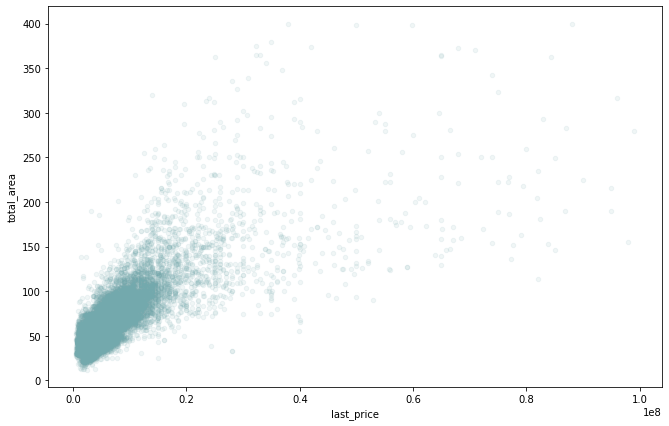

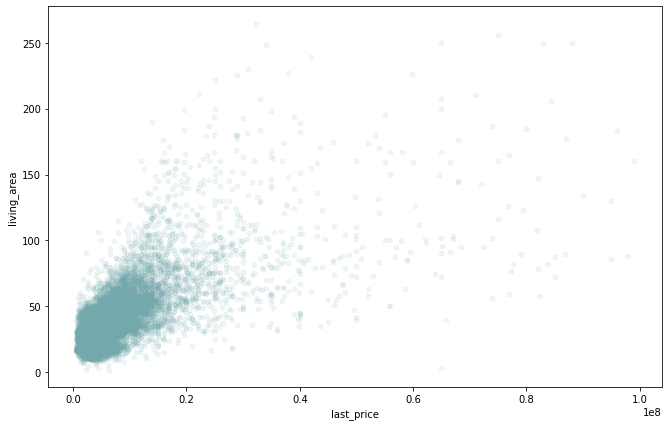

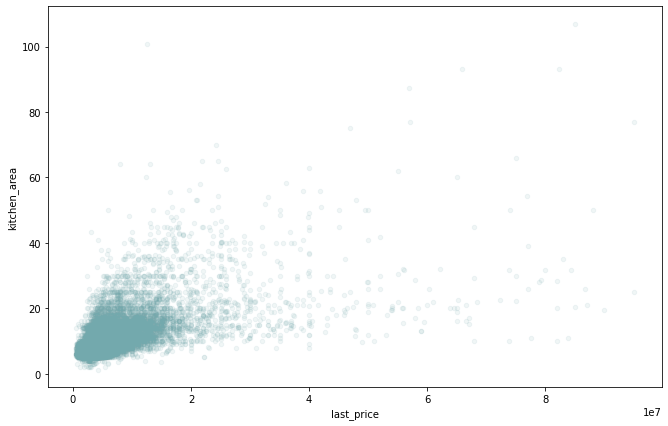

In [ ]:
# построим диаграммы рассеивания используя цикл по  параметрам многочисленным
list_apart_param =  ['total_area','living_area', 'kitchen_area']
for index in list_apart_param:
    df_apart_param.plot(x='last_price', y=index, kind='scatter', alpha=0.1,figsize=(11, 7), color='#73A9AD') 
    

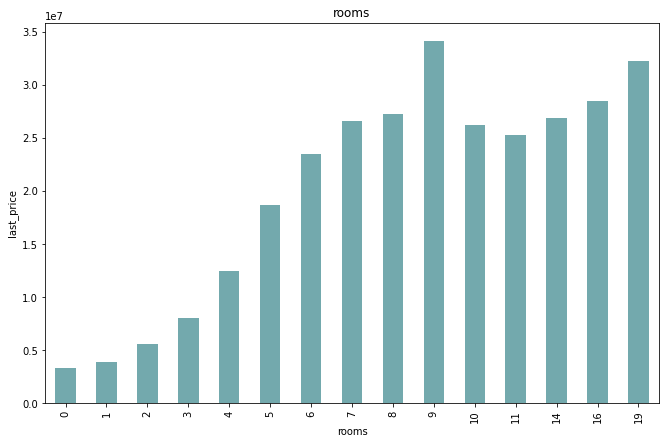

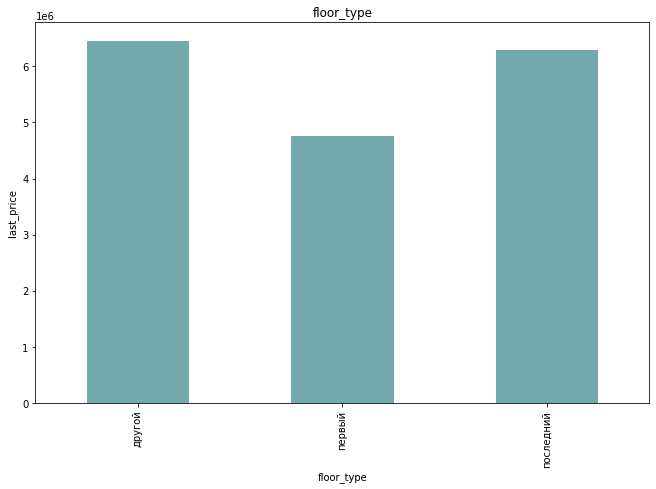

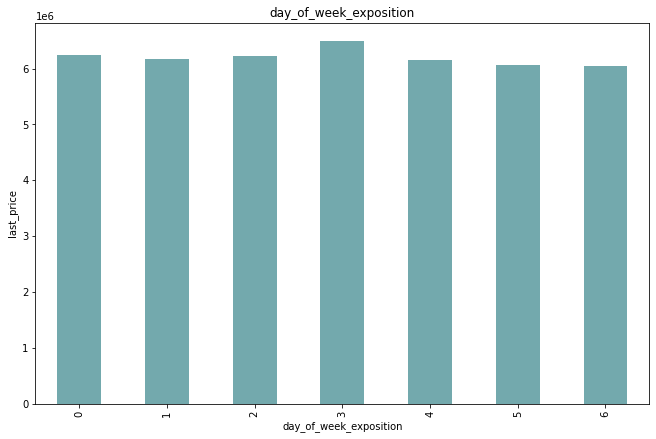

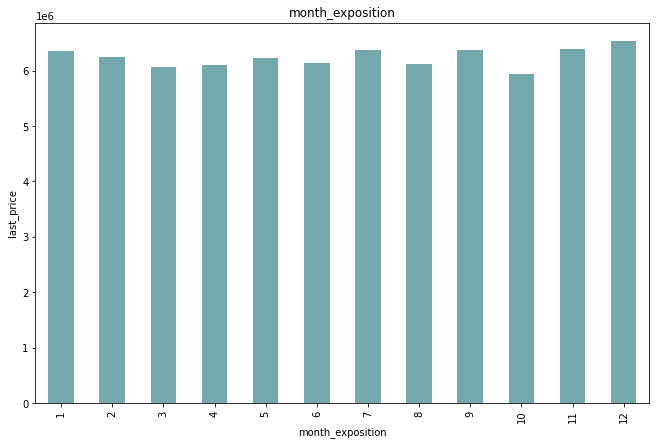

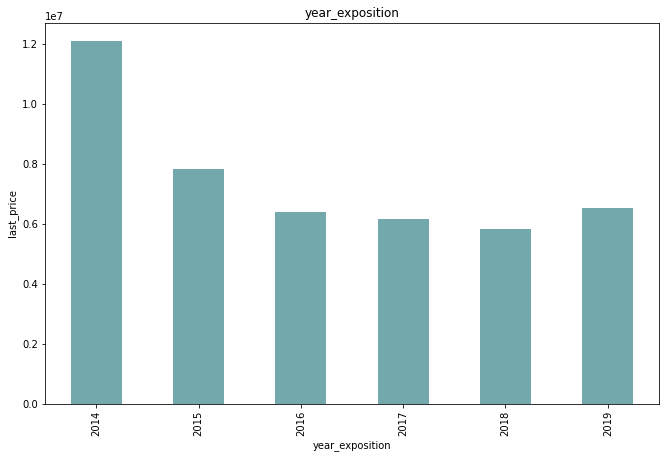

In [ ]:
# построим бары для  количество комнат, категория этажа, а также день, месяц и год размещения
list_apart_param_ = ['rooms','floor_type','day_of_week_exposition','month_exposition','year_exposition']

for index in list_apart_param_:
    plt.title(index)
    plt.ylabel('last_price')
    df_apart_param.groupby(index)['last_price'].mean().plot(kind='bar', figsize=(11, 7), color='#73A9AD') 
    plt.show()
  

**Вывод** Как видноиз кореляции и диаграмм рассеивания больше всего на полную стоимость влияет общая площадь.     
Затем  производные от нее жилая площадь и кухня. Количество комнат относительно слабо влияет.   
Этаж  совсем слабо влияет.     
День, месяц и год размещения объявления не влияют на стоимость квартир.    
Но так же видно, что кваритиры подешевели с 14 года.

**4.3 Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Определение населённых пунктов с самой высокой и низкой стоимостью квадратного метра.**

In [ ]:
# топ 10 населенных пунктов по кол-ву объявлений
df.pivot_table(index='locality_name', values='one_m2_price', aggfunc=('count','mean', 'median' ))\
              .sort_values(by='count', ascending=False).head(10)


,count,mean,median
locality_name,,,
Санкт-Петербург,15668,113603.396274,104687.500000
поселок Мурино,556,85681.762601,85878.462169
поселок Шушары,440,78677.364217,76876.172608
Всеволожск,398,68654.473986,65789.473684
Пушкин,369,103125.819291,100000.000000
Колпино,338,75424.579098,74723.748474
поселок Парголово,327,90175.913458,91642.857143
Гатчина,307,68746.146763,67796.610169
деревня Кудрово,299,92473.547576,91860.465116


In [ ]:
# максимальная стоимость кв м  это СПБ
df.pivot_table(index='locality_name', values='one_m2_price', aggfunc=('count','mean', 'median' ))\
              .sort_values(by='count', ascending=False).head(10)['mean'].max()

113603.39627422557

In [ ]:
# минимальная  Это выборг
df.pivot_table(index='locality_name', values='one_m2_price', aggfunc=('count','mean', 'median' ))\
              .sort_values(by='count', ascending=False).head(10)['mean'].min()

58141.90915331862

In [ ]:
# либо так можно сделать  и видно сразу будет
df_top10 = df.pivot_table(index='locality_name', values='one_m2_price', aggfunc=('count','mean', 'median' ))\
              .sort_values(by='count', ascending=False).head(10)
df_top10.sort_values(by='mean' ,ascending=False)

,count,mean,median
locality_name,,,
Санкт-Петербург,15668,113603.396274,104687.500000
Пушкин,369,103125.819291,100000.000000
деревня Кудрово,299,92473.547576,91860.465116
поселок Парголово,327,90175.913458,91642.857143
поселок Мурино,556,85681.762601,85878.462169
поселок Шушары,440,78677.364217,76876.172608
Колпино,338,75424.579098,74723.748474
Гатчина,307,68746.146763,67796.610169
Всеволожск,398,68654.473986,65789.473684


**Вывод** Самая дорогая цена квадратного метра в СПБ и его пригородах.

**4.4  Квартиры в Санкт-Петербурге  и вычисленее средней цены каждого километра. Как стоимость объектов зависит от расстояния до центра города.**

In [ ]:
#вычисление средней цены ( mean) по километрам удаленнсоть от центра
df.query('km_to_CityCentres >0 and locality_name == "Санкт-Петербург" ' )\
.pivot_table(index='km_to_CityCentres', values='last_price' , aggfunc=('mean', 'median','count'))

,count,mean,median
km_to_CityCentres,,,
1.0,186,1.611297e+07,11150000.0
2.0,304,1.490048e+07,9950000.0
3.0,350,1.112658e+07,8409000.0
4.0,682,1.137441e+07,9170000.0
5.0,907,1.261139e+07,9400000.0
6.0,608,1.342975e+07,8783909.5
7.0,416,1.389639e+07,7797500.0
8.0,596,9.269726e+06,7445000.0
9.0,592,6.962379e+06,5300500.0


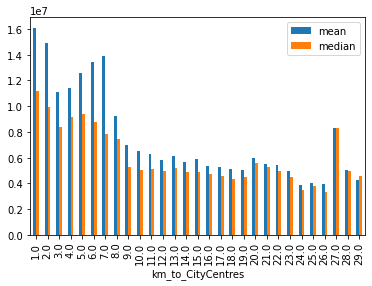

In [ ]:
#график для наглядности
df.query('km_to_CityCentres >0 and locality_name == "Санкт-Петербург" ' )\
.pivot_table(index='km_to_CityCentres', values='last_price' , aggfunc=('mean','median')).plot(kind='bar')

**Вывод**: Цена квартир  в СПБ уменьшается по мере удаления от центра города до 9 км . Далее цена примерно одинакова.   
Так же в самом центре на графике отчетливо видно,что среднее арифм больше медианы. Это говрит о том ,ч то в центре есть относительно небольшое кол-во очень дорогих квартир. Которые вносят значительный вклад в среднее значение.

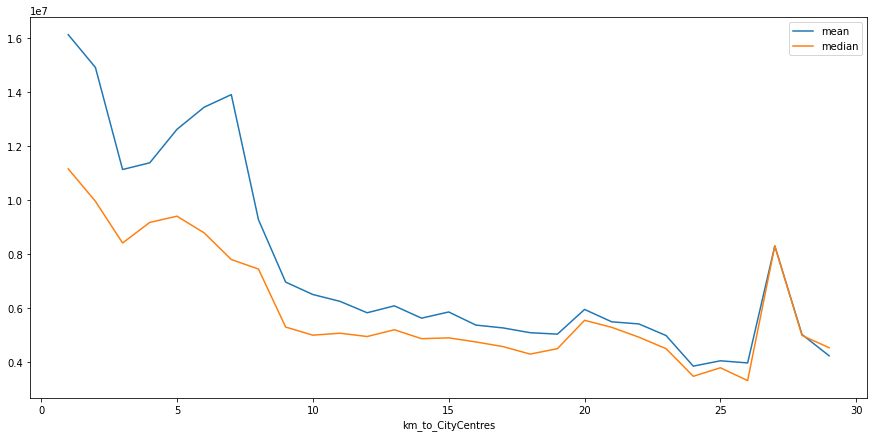

In [ ]:
df.query('km_to_CityCentres >0 and locality_name == "Санкт-Петербург" ' )\
.pivot_table(index='km_to_CityCentres', values='last_price' , aggfunc=('mean','median')).plot(figsize=(15, 7))

plt.show()

### 5.Общий вывод

В ходе исследования были проанализирвоанные данные базы объявлений по продаже квартир в СПБ и области.    
Большая часть объявлений  это небольшие квартиры в 5 и 9 этажных домах площадью 30-60 кв м.      
По географии  больщая часть это квартиры в СПБ и пригородах.    
Обычно продажа занимает 95 дней, быстрые продажи это меньше 45 дней, необычно долгие это свыше 500 дней.    
Выявлена зависимость различных факторов от стоимости  жилья.     
Больше всего оказывает влияние на стомость : населенный пункт, площадь квартиры(и ее производные как жилая и кухни площадь, удаленность от центра для СПБ. Меньше: кол-во комнат, тип этажа.    
Не влияет день недели, месяц, год размещения объявления.     
Так же видно,ч то с 14 года квартиры дешевеют в среднем, в 19 году наметилось небольшое увеличение средней цены.   
Стоит учесть, что большинство объявлений добавлются в рабочии дни, скорее всего риелторами. Так же наблюдается сезонный спад размещений объявлений в январе и мае.